### Import Packages

In [1]:
import pandas as pd
import numpy as np
import datetime

### Defining certain functions

#### 1. To rename the columns
I performed some clean up for the column names to make them more readable, to remove characters like “/“, and to make everything lower case.

The input argument called input_data that enables to pass a DataFrame into the function.

Pandas is used to0 rename method to rename the columns of the DataFrame. The output is returned using output_data.

In [2]:
def covid_rename_columns(input_data):
    output_data = input_data.rename(
                              columns = {'Province/State':'subregion'
                                         ,'Country/Region':'country'
                                         ,'Lat':'lat'
                                         ,'Long':'long'
                                         }
                              )
    return(output_data)

#### 2. Fill missing values
This function is created to fill in some missing values in the the subregion variable.
This will fill in NaN values with an empty string.

In [3]:
def covid_fill_missing(input_data):
    output_data = input_data.fillna(value = {'subregion':''})
    return(output_data)

#### 4. Melting the data 
It is a function to reshape the data into a “tidy” shape.

The dates in the raw data exist as separate columns.I want the dates to exist as values underneath a single date column.

This function will accept a DataFrame as the first argument, and a variable name (a string) as the second argument.

The function reshapes the data so that the dates (which are columns in the original data) will be transposed into values. At the same time, it creates a value variable that can be nameed. 

In [4]:
def covid_melt_data(input_data, value_var_name):
    output_data = input_data.melt(id_vars = ['country','subregion','lat','long']
                                  ,var_name = 'date_RAW'
                                  ,value_name = value_var_name
                                  )
    return(output_data)

#### 5. Converting the dates
The date to be in a “datetime” format. This can be done by simply using the Pandas to_datetime method to create a new field called “date“.

Pandas assign method is used to create a new variable.

The to_datetime function to transform date_RAW into a proper datetime.

The date_RAW field is deleted by using the drop method.

So in from the input data, I have taken the date_RAW field, used that to create a datetime called date, droped the original date_RAW column, and then returned the output, output_data.

In [5]:
def covid_convert_dates(input_data):
    output_data = input_data.assign(
         date = pd.to_datetime(input_data.date_RAW, format='%m/%d/%y')
         )
    output_data.drop(columns = ['date_RAW'], inplace = True)
    return(output_data)

#### 6. Rearrange the data
Even after most of the data processing, the data were still a little “disordered”.

I have shifted the date column form the last few columns to first few columns. 

Also, I have reorderred the columns such that reordering has put country, subregion, and date towards the front, among the first few columns.

I sorted the rows using the sort_values to sort the rows by country, subregion, and date.

The function returns a DataFrame..


In [6]:
def covid_rearrange_data(input_data,value_var_name):
    output_data = (input_data
                   .filter(['country', 'subregion', 'date', 'lat', 'long', value_var_name])
                   .sort_values(['country','subregion','date','lat','long'])
                   .reset_index(drop = True)
                   )
    return(output_data)

#### 7. Get and wrangle data 
I have created a function that just combines all the previous functions into a single function.

The new function, covid_get_data, accepts a URL as the first argument followed by value_var_name.It is used to create different “value” variables for different covid-19 datasets.



In [7]:
def covid_get_data(input_url, value_var_name):
    covid_data_inprocess = pd.read_csv(input_url)
    covid_data_inprocess = covid_rename_columns(covid_data_inprocess)
    covid_data_inprocess = covid_fill_missing(covid_data_inprocess)
    covid_data_inprocess = covid_melt_data(covid_data_inprocess,value_var_name)
    covid_data_inprocess = covid_convert_dates(covid_data_inprocess)
    covid_data_inprocess = covid_rearrange_data(covid_data_inprocess, value_var_name)
    return(covid_data_inprocess)

### Get Data
I have loaded three datasets.

In [8]:
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

covid_confirmed = covid_get_data(url_confirmed,'confirmed')
covid_deaths = covid_get_data(url_deaths,'dead')
covid_recovered = covid_get_data(url_recovered,'recovered')

### Print Data 

In [9]:
print(covid_confirmed)

           country subregion       date        lat       long  confirmed
0      Afghanistan           2020-01-22  33.939110  67.709953          0
1      Afghanistan           2020-01-23  33.939110  67.709953          0
2      Afghanistan           2020-01-24  33.939110  67.709953          0
3      Afghanistan           2020-01-25  33.939110  67.709953          0
4      Afghanistan           2020-01-26  33.939110  67.709953          0
...            ...       ...        ...        ...        ...        ...
48939     Zimbabwe           2020-07-19 -19.015438  29.154857       1611
48940     Zimbabwe           2020-07-20 -19.015438  29.154857       1713
48941     Zimbabwe           2020-07-21 -19.015438  29.154857       1820
48942     Zimbabwe           2020-07-22 -19.015438  29.154857       2034
48943     Zimbabwe           2020-07-23 -19.015438  29.154857       2124

[48944 rows x 6 columns]


The covid_confirmed contains the countries, dates, locations, and confirmed covid-19 cases.
covid_deaths contains deaths, and covid_recovered contains recovered cases.


### Get record counts 

In [10]:
len(covid_confirmed) 

48944

In [11]:
len(covid_deaths)    

48944

In [12]:
len(covid_recovered) 

46552

### Merge Data 
I have merged1 these 3 datasets together. I need to merge together covid_confirmed, covid_deaths, and covid_recovered.

It will give a single DataFrame that contains covid-19 confirmed cases, deaths, and recoveries at the level of location-date.

#### Drop the columns which are not needed
I have dropped some extra variables like lat and long in covid_deaths and covid_recovered.

In [13]:
covid_deaths.drop(columns = ['lat','long'], inplace = True)
covid_recovered.drop(columns = ['lat','long'], inplace = True)

In [14]:
covid_data = (covid_confirmed
                .merge(covid_deaths, on = ['country','subregion','date'], how = 'left')
                .merge(covid_recovered, on = ['country','subregion','date'], how = 'left')
             )

This is a “left” merge, which means that the merge process will keep all of the rows from covid_confirmed, and tack on any additional columns from covid_deaths and covid_recovered.

In [15]:
print(covid_data)

           country subregion       date        lat       long  confirmed  \
0      Afghanistan           2020-01-22  33.939110  67.709953          0   
1      Afghanistan           2020-01-23  33.939110  67.709953          0   
2      Afghanistan           2020-01-24  33.939110  67.709953          0   
3      Afghanistan           2020-01-25  33.939110  67.709953          0   
4      Afghanistan           2020-01-26  33.939110  67.709953          0   
...            ...       ...        ...        ...        ...        ...   
48939     Zimbabwe           2020-07-19 -19.015438  29.154857       1611   
48940     Zimbabwe           2020-07-20 -19.015438  29.154857       1713   
48941     Zimbabwe           2020-07-21 -19.015438  29.154857       1820   
48942     Zimbabwe           2020-07-22 -19.015438  29.154857       2034   
48943     Zimbabwe           2020-07-23 -19.015438  29.154857       2124   

       dead  recovered  
0         0        0.0  
1         0        0.0  
2         0 

### Calculate daily new cases

In [16]:
new_cases_ALL = (covid_data
 .sort_values(by = ['country', 'subregion', 'date'])
 .filter(['country','subregion','date','confirmed'])
 .groupby(['country','subregion'])
 .confirmed
 .diff()
)

To add the new cases to the covid_data dataframe:

In [17]:
covid_data = covid_data.assign(new_cases = new_cases_ALL)

In [18]:
covid_data.head()

,country,subregion,date,lat,long,confirmed,dead,recovered,new_cases
0,Afghanistan,,2020-01-22,33.93911,67.709953,0,0,0.0,NaN
1,Afghanistan,,2020-01-23,33.93911,67.709953,0,0,0.0,0.0
2,Afghanistan,,2020-01-24,33.93911,67.709953,0,0,0.0,0.0
3,Afghanistan,,2020-01-25,33.93911,67.709953,0,0,0.0,0.0
4,Afghanistan,,2020-01-26,33.93911,67.709953,0,0,0.0,0.0


To check the column names 

In [19]:
covid_data.columns

Index(['country', 'subregion', 'date', 'lat', 'long', 'confirmed', 'dead',
       'recovered', 'new_cases'],
      dtype='object')

To check unique values for every country:

In [20]:
pd.set_option('display.max_rows', 180)

covid_data.filter(['country']).drop_duplicates()


,country
0,Afghanistan
184,Albania
368,Algeria
552,Andorra
736,Angola
...,...
48024,West Bank and Gaza
48208,Western Sahara
48392,Yemen
48576,Zambia


In [21]:
covid_data.filter(['date']).drop_duplicates()

,date
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26
...,...
179,2020-07-19
180,2020-07-20
181,2020-07-21
182,2020-07-22


To retrieve the minimum and maximum values for both lat and long:

In [22]:
covid_data.filter(['long','lat']).agg(['min','max'])

,long,lat
min,-135.000,-51.7963
max,178.065,71.7069


To describe numerical variables confirmed, dead, and recovered columns by summary statistics.

In [23]:
covid_data.filter(['confirmed','dead','recovered']).describe()

,confirmed,dead,recovered
count,4.894400e+04,48944.000000,4.636800e+04
mean,1.559492e+04,833.598868,7.589283e+03
std,1.184579e+05,6074.896763,5.102345e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,3.000000e+00,0.000000,0.000000e+00
50%,1.470000e+02,2.000000,4.500000e+01
75%,1.355250e+03,26.000000,7.100000e+02
max,4.038748e+06,144304.000000,1.620313e+06


To count the missing values:

In [24]:
covid_data.isnull().sum()

country         0
subregion       0
date            0
lat             0
long            0
confirmed       0
dead            0
recovered    2576
new_cases     266
dtype: int64

There are no missing values in any of the columns except recovered and new_cases. 
 

In [25]:
pd.set_option('display.max_rows', 300)
(covid_data
   .filter(['country','date','confirmed','dead','recovered'])
   .groupby(['country','date'])
   .agg('sum')
   .query('date == datetime.date(2020, 3, 21)')
   .query('country in ["US","Italy","France","China"]')
)

,,confirmed,dead,recovered
country,date,,,
China,2020-03-21,81305,3259,71857.0
France,2020-03-21,14463,563,12.0
Italy,2020-03-21,53578,4825,6072.0
US,2020-03-21,25825,456,176.0


The code has given us a quick summary of the confirmed, dead, and recovered for China, France, Italy, and the US

# Data visualisation
For the front end visualization part, I have used Seaborn. Seaborn is a data visualization package for Python.

In [26]:
import seaborn as sns
import numpy as np

#### To set the formatting for the charts:

In [27]:
sns.set()

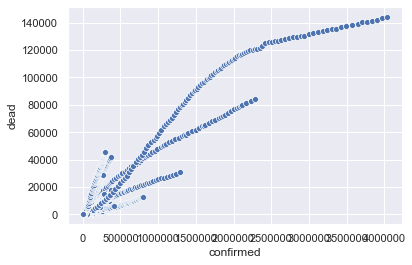

In [28]:
sns.scatterplot(data = covid_data
                ,x = 'confirmed'
                ,y = 'dead'
                )

To create a line chart of covid-19 cases verses time, excluding China.

In [29]:
confimed_by_date_xchina = (covid_data
                           .query('country != "China"')
                           .filter(['date','confirmed'])
                           .groupby('date')
                           .agg('sum')
                           .reset_index()
                           )

In [30]:
print(confimed_by_date_xchina)

          date  confirmed
0   2020-01-22          7
1   2020-01-23         11
2   2020-01-24         21
3   2020-01-25         28
4   2020-01-26         43
5   2020-01-27         50
6   2020-01-28         69
7   2020-01-29         79
8   2020-01-30         93
9   2020-01-31        125
10  2020-02-01        147
11  2020-02-02        157
12  2020-02-03        171
13  2020-02-04        191
14  2020-02-05        203
15  2020-02-06        215
16  2020-02-07        285
17  2020-02-08        315
18  2020-02-09        330
19  2020-02-10        414
20  2020-02-11        424
21  2020-02-12        469
22  2020-02-13        486
23  2020-02-14        550
24  2020-02-15        637
25  2020-02-16        721
26  2020-02-17        835
27  2020-02-18        940
28  2020-02-19       1032
29  2020-02-20       1134
30  2020-02-21       1290
31  2020-02-22       1600
32  2020-02-23       1957
33  2020-02-24       2302
34  2020-02-25       2642
35  2020-02-26       3207
36  2020-02-27       4137
37  2020-02-

C:\Users\Divya Sharma\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


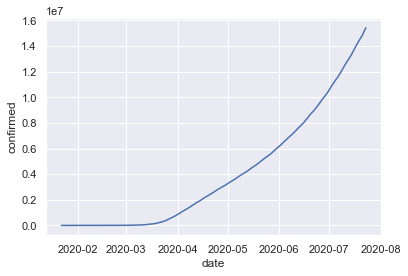

In [31]:
sns.lineplot(data = confimed_by_date_xchina
             ,x = 'date'
             ,y = 'confirmed'
             )

It shows the rapid rise of worldwide covid19 cases.

### LINE CHART OF WORLD COVID-19 CASES OVER TIME, CHINA VS WORLD
A line chart that shows two lines. One line for China, and another line for the rest of the world.

The first step is just creating a new categorical variable called china_flg. This variable has two values.

It is “China” if the country variable is China, and “Not China” otherwise. 

To create this variable, I have the Pandas assign method, and the Numpy where function to conditionally assign the values “China” or “Not China”, depending on the value of the country variable.
 
This is followed by aggregation.

In [32]:
confirmed_by_date_china_xchina = (covid_data
                           .assign(china_flg = np.where(covid_data.country == 'China', 'China', 'Not China'))
                           .filter(['date','confirmed','china_flg'])
                           .groupby(['date','china_flg'])
                           .agg('sum')
                           .reset_index()
                           )

In [33]:
print(confirmed_by_date_china_xchina)

          date  china_flg  confirmed
0   2020-01-22      China        548
1   2020-01-22  Not China          7
2   2020-01-23      China        643
3   2020-01-23  Not China         11
4   2020-01-24      China        920
..         ...        ...        ...
363 2020-07-21  Not China   14862114
364 2020-07-22      China      85906
365 2020-07-22  Not China   15142527
366 2020-07-23      China      86045
367 2020-07-23  Not China   15425112

[368 rows x 3 columns]


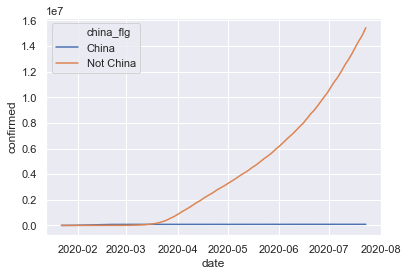

In [34]:
sns.lineplot(data = confirmed_by_date_china_xchina
             ,x = 'date'
             ,y = 'confirmed'
             ,hue = 'china_flg'
             )

### LINE CHART OF IMPORTANT COUNTRIES OVER TIME

I have created a line chart that plots cases for a few countries with major outbreaks, US, China, India, Spain, and France.

In [35]:
confirmed_by_date_top_countries = (covid_data
                           .filter(['date','country','confirmed'])
                           .query('country in ["US","China","India","Spain","France"] ')
                           .groupby(['date','country'])
                           .agg('sum')
                           .reset_index()
                           )

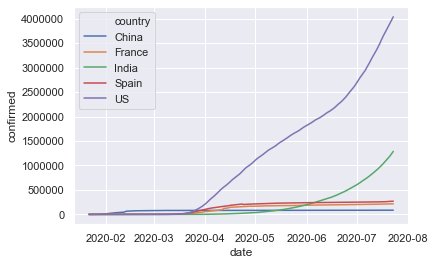

In [36]:
sns.lineplot(data = confirmed_by_date_top_countries
             ,x = 'date'
             ,y = 'confirmed'
             ,hue = 'country'
             )

This is done to compare the growth of covid19 cases over time for different countries.

### Bar charts

I wanted to make a bar chart that shows the number of cases, by country, for the top 15 countries.
1. Create a DataFrame with the top 15 countries with the most confirmed covid19 case, using several Pandas methods, chained together. 
2. Use Pandas query to subset down to the data.
3. Retrive only the country and confirmed variables.
4. Group and aggregate the data to sum up the confirmed cases by country.
5. Sort the values in descending order using sort values, using iloc to slice the data and retrieve the top 15 rows.


In [37]:
confirmed_by_country_top15 = (covid_data
                        .query('date == datetime.date(2020, 3, 29)')
                        .filter(['country','confirmed'])
                        .groupby('country')
                        .agg('sum')
                        .sort_values('confirmed', ascending = False)
                        .reset_index()
                        .iloc[0:15,:]
                        )

In [38]:
print(confirmed_by_country_top15)

           country  confirmed
0               US     141205
1            Italy      97689
2            China      82122
3            Spain      80110
4          Germany      62095
5           France      40708
6             Iran      38309
7   United Kingdom      29954
8      Switzerland      14829
9      Netherlands      10930
10         Belgium      10836
11    Korea, South       9583
12          Turkey       9217
13         Austria       8788
14          Canada       6280


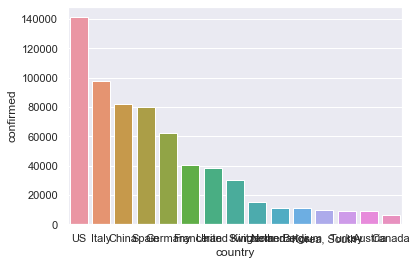

In [43]:
sns.barplot(data = confirmed_by_country_top15
            ,x = 'country'
            ,y = 'confirmed'
        )

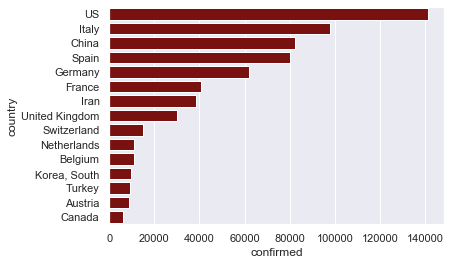

In [40]:
sns.barplot(data = confirmed_by_country_top15
            ,y = 'country'
            ,x = 'confirmed'
            ,color = 'darkred'
        )